# Word2vec model based on Fetahu
This model uses a pretrained word2vec to vectorize the paragraphs, the sequential information of the sentences is maintained.

A pretrained word2vec can be found on [this github repo](https://github.com/3Top/word2vec-api).

The paper this is based on can be found [here](https://arxiv.org/pdf/1811.05740.pdf).

In [3]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from gensim.test.utils import datapath
from gensim.models import KeyedVectors
from sklearn.metrics import confusion_matrix
from gensim.utils import simple_preprocess
import itertools
from gg_doc2vec import read_corpus, ggdoc2vec_train

In [5]:
df = pd.read_csv("../../data/ad_hominem/ad_hominems_cleaned_Murilo.csv", sep=",", index_col=0, header=0, names=["body", "isAdHominem"])
df = df[~df.isin([np.nan, np.inf, -np.inf, 'nan']).any(1)] ## Remove rows with NaN values
df = df[0:3000]

In [6]:
df["length"] = df["body"].apply( lambda x: len(simple_preprocess(x, deacc=True)))

In [7]:
print("Setting paragraph length at {} words.".format(df["length"].max()))

Setting paragraph length at 2092 words.


In [8]:
from sklearn.model_selection import train_test_split

train, test = train_test_split( df, test_size=0.3, random_state=1)

print("In total, the train contains", sum(train["isAdHominem"] == True), "ad hominems")
print("In total, the test contains", sum(test["isAdHominem"] == True), "ad hominems")

In total, the train contains 279 ad hominems
In total, the test contains 121 ad hominems


In [54]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [33]:
print("importing word2vec")
wv_from_bin = KeyedVectors.load_word2vec_format(datapath("/Users/pieterdelobelle/Downloads/GoogleNews-vectors-negative300.bin.gz"), binary=True)  # C binary format
print("imported word2vec")

importing word2vec
imported word2vec


In [31]:
docVectorLength = 500
docModel = ggdoc2vec_train(train, vec_size=docVectorLength)

In [28]:
def combineData( dataset, maxLength, docVectorLength ):
    #dataset["length"] = dataset["body"].apply( lambda x: len(word_tokenize(x)))
    #maxLength = dataset["length"].max()    
    paragraphRepresentations = np.zeros((len(dataset), maxLength, 300))
    docVectors = np.zeros((len(dataset), docVectorLength))
    
    for i, paragraph in enumerate(dataset["body"]):
        if (100* i / dataset.shape[0] % 10 == 0):
            print("{} of {} ({} %)\r".format(i, dataset.shape[0], 100* i / dataset.shape[0]))
        #text = word_tokenize(paragraph)
        #tags = np.array(nltk.pos_tag(text))
        
        # Split the sentence into an array of (cleaned) words
        splittedSentence = simple_preprocess(paragraph, deacc=True)
        
        # Generate docVector first
        docVectors[i] = docModel.infer_vector(splittedSentence)
        
        # Enumerate over the words in the tags-array (col 0 = words, col 1 = POS tags)
        for j, word in enumerate(splittedSentence):
            #print("{}: {} ({})".format(i, j, word))
            if word.lower() in wv_from_bin:
                paragraphRepresentations[i, j] = wv_from_bin[word.lower()] 
    return paragraphRepresentations, docVectors

In [34]:
maxLength = df["length"].max() 
print("Start train data")
train_vectors, train_doc_vectors = combineData(train, maxLength, docVectorLength)

Start train data
0 of 2100 (0.0 %)
210 of 2100 (10.0 %)
420 of 2100 (20.0 %)
630 of 2100 (30.0 %)
840 of 2100 (40.0 %)
1050 of 2100 (50.0 %)
1260 of 2100 (60.0 %)
1470 of 2100 (70.0 %)
1680 of 2100 (80.0 %)
1890 of 2100 (90.0 %)


In [51]:
test_vectors, test_doc_vectors = combineData(test, maxLength, docVectorLength)

0 of 900 (0.0 %)
90 of 900 (10.0 %)
180 of 900 (20.0 %)
270 of 900 (30.0 %)
360 of 900 (40.0 %)
450 of 900 (50.0 %)
540 of 900 (60.0 %)
630 of 900 (70.0 %)
720 of 900 (80.0 %)
810 of 900 (90.0 %)


In [41]:
batch_size = 50
epochs = 10

## Fix imbalance

In [58]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train["isAdHominem"]),
                                                 train["isAdHominem"])

In [115]:
1/class_weights

array([1.73, 0.27])

In [87]:
from keras.layers import Input, Embedding, GRU, Dense, Masking, Bidirectional, concatenate
from keras.models import Model

word2vecInput = Input(shape=(maxLength, 300), name='word2vec')
doc2vecInput = Input(shape=(docVectorLength,), name='doc2vec')

# Network for word vectors
x = Masking(mask_value=0., input_shape=(maxLength, 300))(word2vecInput)
x = Bidirectional(GRU(250, return_sequences=True), merge_mode='ave')(x) 
wordout = Bidirectional(GRU(250), merge_mode='ave')(x)

# Add word vectors and doc vectors together
x = concatenate([wordout, doc2vecInput])
x = Dense(64)(x)
output = Dense(2, activation="softmax", name="output")(x)

model = Model(inputs=[word2vecInput, doc2vecInput], outputs=[output])

model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [110]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
word2vec (InputLayer)           (None, 2092, 300)    0                                            
__________________________________________________________________________________________________
masking_8 (Masking)             (None, 2092, 300)    0           word2vec[0][0]                   
__________________________________________________________________________________________________
bidirectional_11 (Bidirectional (None, 2092, 250)    826500      masking_8[0][0]                  
__________________________________________________________________________________________________
bidirectional_12 (Bidirectional (None, 250)          751500      bidirectional_11[0][0]           
__________________________________________________________________________________________________
doc2vec (I

In [ ]:
history = model.fit(
            {'word2vec': train_vectors, 'doc2vec': train_doc_vectors},
            {'output': np.array([train["isAdHominem"], 1-train["isAdHominem"]]).T},
            epochs=epochs,
            batch_size=batch_size,
            verbose=1,
            validation_split=0.1,
            class_weight=1/class_weights)

Train on 1890 samples, validate on 210 samples
Epoch 1/10
 250/1890 [==>...........................] - ETA: 8:29 - loss: 0.1856 - acc: 0.9120

In [91]:
test_predicted = model.predict({'word2vec': test_vectors, 'doc2vec': test_doc_vectors})

In [67]:
model.save_weights("model04.h5")

Confusion matrix, without normalization
[[762  17]
 [ 94  27]]
Normalized confusion matrix
[[0.98 0.02]
 [0.78 0.22]]


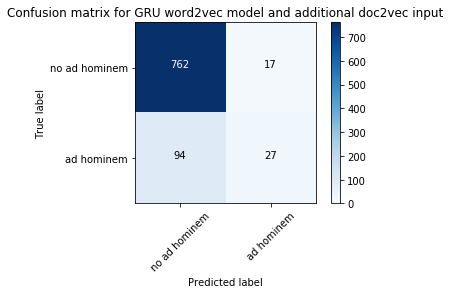

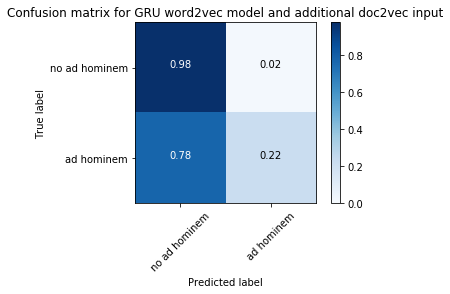

In [101]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(test["isAdHominem"], test_predicted[:,0] > 0.5)

np.set_printoptions(precision=2)

title="Confusion matrix for GRU word2vec model and additional doc2vec input"

# Plot normalized confusion matrix
fig = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["no ad hominem", "ad hominem"],normalize=False, 
                      title=title)

#print('plots exported.png')
fig.savefig("model05_not_normalized.png")

# Plot non-normalized confusion matrix
fig = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["no ad hominem", "ad hominem"],normalize=True, 
                      title=title)
fig.savefig("model05_normalized.png")

## Finally evaluate loss on train and validation set

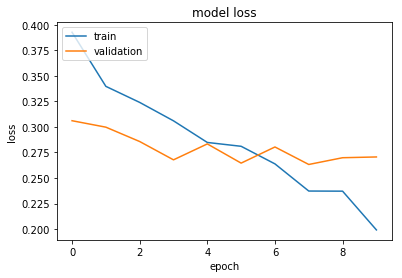

In [90]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()